# One layer of Decoder consists of:
1. Self-Attention
2. Masked Multi-Head Attention
3. Positional Embeddings
4. Cross-Attention
5. Multi-Head Cross Attention
6. Feed forward Network
7. Residual Connection and Layer Normalization

In [1]:
from IPython.display import Image, display

## Masked Multi-Head Attention

### Working of Self-Attention

__0__. Input $X$: Sequence of __token embeddings__, of size *(Seq_Length X Embedding_Dim)*. Output $S$: Sequence of __contextual representation__, of size *(Seq_Length X Embedding_Dim)*.


__1__. For each input token $x_t$, the output of Self-Attention Module is a contextual representation $s_t$ which is the __"attention-weighted"__ average of all input tokens (embeddings) in the sequence. 

__2__. For ex: if there are L (Seq_Length) token embeddings in the input, then the output $s_t$, corresponding to $t_{th}$ input token $x_t$ is given by: 
    $$ s_t = \sum_{i=1}^{L}\alpha_{ti} * x_i $$
where $\alpha_{ti}$ is the attention weight given to $i_{th}$ input token $x_i$ while creating the representation for $t_{th}$ output token $s_t$. So, the output of Self-Attention will have __same number of tokens__ as in input.

__3__. A simple way to calculate $\alpha_t$ for $s_t$ is to compute the similarity_score of $x_t$ with all other tokens in the sequence (inlcuding itself) and take a softmax on that, i.e
    $$\alpha_t = softmax([x_t.x_1, x_t.x_2, ..., x_t.x_L])$$
where __'.'__ denotes dot-product.

__4__. In Matrix form, if we denote matrix $X$ as input sequence, of size *(Seq_Length X Embedding_Dim)*, then the Attention Weights $\mathrm{A}$ is given by:
    $$\mathrm{A} = softmax(XX^T, dim=1)$$
$X^T$ is X Transpose of size *(Embedding_Dim X Seq_Length)*, and $\mathrm{A}$ is of size *(Seq_Length X Seq_Length)*. So the output matrix $S$ can be denoted by:
    $$S = \mathrm{A}X$$
so that $S$ is of size *(Seq_Length X Embedding_Dim)*.

__5__. However, to get different attention_weight for different tokens, we have to solely rely on the __token embeddings__. For ex: the embedding of token "__it__" in the above example has to be such that in the first sentence it should have high similarity with __dog__ and in the second sentence, it should have high similarity with __street__. We clearly need to do better and be more flexible with the modelling choice of $\mathrm{A}$.

__6__. Let's create a new matrix $\tilde{X}$ of size *(Seq_Length X Embedding_Dim)* by introducing a learnable parameter $P$ of size *(Embedding_Dim X Embedding_Dim)* such that  $\tilde{X} = XP$. Now, $S$ can be written as:
    $$ S = \mathrm{A}\tilde{X}$$
    $$ S = softmax(\tilde{X}\tilde{X}^T)\tilde{X}$$
    $$ S = softmax(XPP^TX^T)(XP)$$

__7__. While this gives us much flexibility for $\mathrm{A}$, but the matrix $XPP^TX^T$ is symmetric. Quoting from "Bishop's Deep Learning" book: 
*We would like attention_weights to be highly asymmetric. For ex: "chisel" should be strongly associated with "tool" as every "chisel" is a tool, but "tool" should be loosely associated with "chisel" as tools are of many other kinds. Furthermore, we are using the same parameter $P$ to define both the value matrix $X$ and the attention-weights $\mathrm{A}$, which also seems like undesirable restriction.* 

__8__. We can overcome both these limitations by defining three different learnable params: $W_Q, W_K, W_V$ each of size *(Embedding_Dim X Embedding_Dim)*, such that: 
    $Q = XW_Q$ of size *(Seq_Length X Embedding_Dim)*
    $K = XW_K$ of size *(Seq_Length X Embedding_Dim)*
    $V = XW_V$ of size *(Seq_Length X Embedding_Dim)*
so that, we can define $S$ as:
    $$ S = softmax(QK^T)V $$

__9__. We also scale the $QK^T$ matrix by __square-root__ of size of $W_K$. By size, we mean column, as __#num_rows__ has to be of *Embedding_Dim* for matrix multiplication compatibility. Here, the size of $W_K$ is also *Embedding_Dim*, However, as we will see later in the __Multi-Head__ attention, the size of $W_Q, W_K$, and $W_V$ matrix will be of *Head_Dim*. So, the final equation for $S$ is:
    $$ S = softmax(\frac{QK^T}{\sqrt{Embedding\_Dim}})V $$
    
__10__. This particular form of attention equation $softmax(\frac{QK^T}{\sqrt{Embedding\_Dim}})$ is also called __scaled dot product attention__.

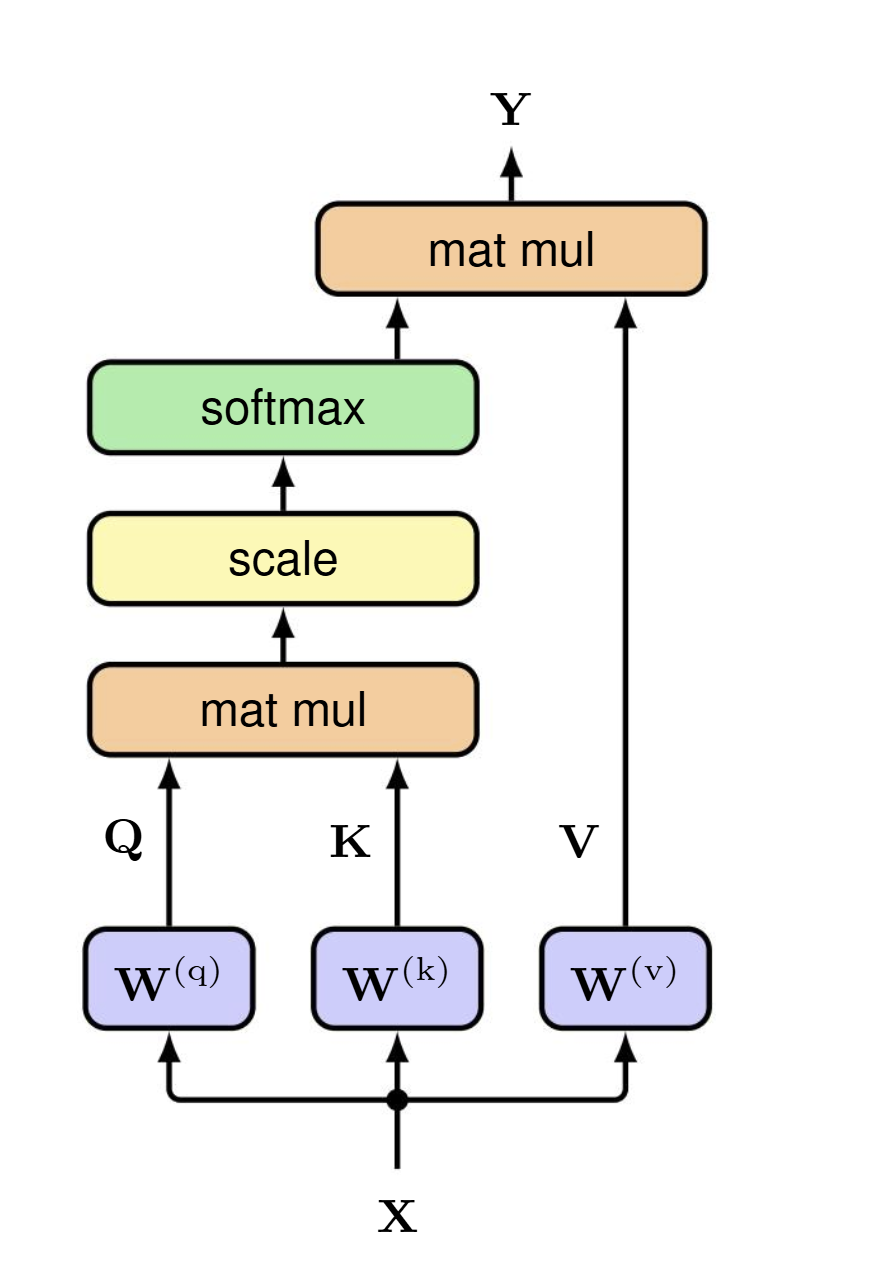

In [2]:
display(Image(filename='img/SelfAttention.png', width=200, height=100))

### Multi-Head Attention

__1__. Generally, one context matrix $S$ is not sufficient in itself to learn multiple different contexts of tokens.

__2__. We intialize multiple such Self-Attention __Heads__ (traditionally 8), each of them having their own set of params $W_q, W_k, W_v$. So now we get __#num_heads__ context matrices $S$. We then concat all the context matrices for downstream task. 

__3__. Since, there are __#num_heads__ Self-Attention modules, so we reduce the size of $W_q, W_k, W_v$ matrices from *(Embedding_Dim X Embedding_Dim)* to *(Embedding_Dim X Head_Dim)*, where __*Head_Dim*__ is defined as:
    $$ Head\_Dim = \frac{Embedding\_Dim}{num\_heads} $$

__4__. So each context matrix $S_i$ is of size *(Embedding_Dim X Head_Dim)*. We concat them along axis=1 to get back the final context matrix of size *(Embedding_Dim X Embedding_Dim)*:
    $$ S = torch.cat([S_1, S_2, ..., S_{num\_heads}], axis = 1) $$

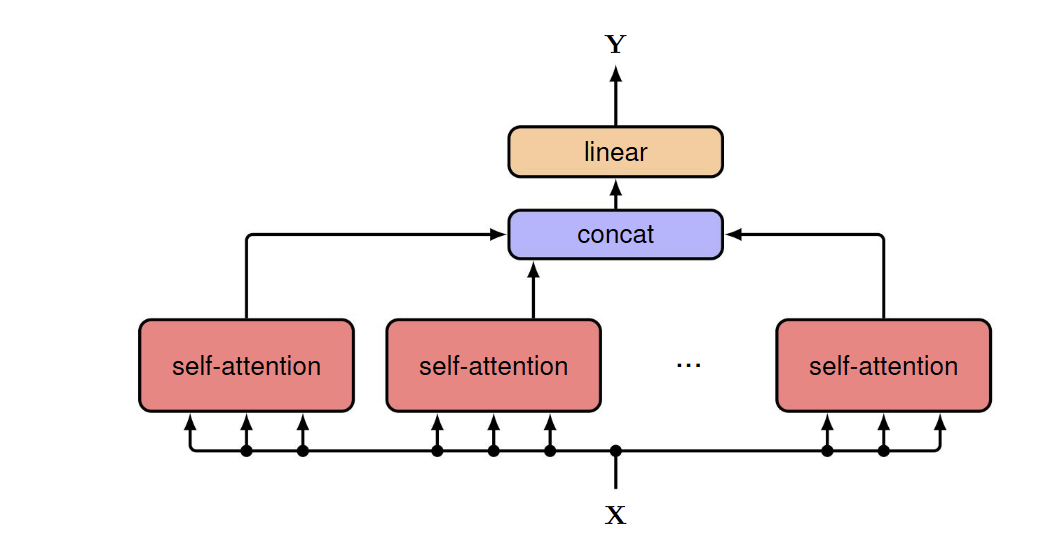

In [3]:
display(Image(filename='img/MultiHeadAttention.png', width=500, height=400))

### Define Model 

In [4]:
import torch.nn as nn
import torch
import random
import os
import pandas as pd
from itertools import chain
import math

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim, head_dim):
        super(SelfAttention, self).__init__()
        self.head_dim = head_dim
        self.K = torch.randn(embedding_dim, head_dim, requires_grad=True)
        self.Q = torch.randn(embedding_dim, head_dim, requires_grad=True)
        self.V = torch.randn(embedding_dim, head_dim, requires_grad=True)
    
    def forward(self, embedded_x, mask_matrix = None, debug = False):
        # Batch_Size = B, Seq_Length = L, Embedding_Dim = D, Head_Dim = H
        # embedded_x shape = (B X L X D)
        q = torch.matmul(embedded_x, self.Q) # q shape = (B X L X H)
        k = torch.matmul(embedded_x, self.K) # k shape = (B X L X H)
        v = torch.matmul(embedded_x, self.V) # v shape = (B X L X H)
        
        scores = torch.bmm(q, k.transpose(1,2))/math.sqrt(self.hidden_dim)
        # scores shape = (B X L X L)
        # torch.bmm() does the batch matrix multiplication:
        # input_1 = (b X n X m), input_2 = (b X m X p)
        # op = torch.zeros(b X n X p)
        # for each matrix (n X m) in input_1 and (m X p) in input_2, 
        # torch.bmm() will output an (n X p) matrix. 
        # This will be done 'b' times (i.e for all b matrices)
        
        if mask_matrix:
            scores = scores.masked_fill(mask_matrix==0, float("-inf"))
        weights = torch.softmax(scores, dim=2) # (B X L X L)
        output = torch.bmm(weights, v) # (B X L X H)
        
        if debug:
            print("q shape:", q.shape)
            print("k shape:", k.shape)
            print("v shape:", v.shape)
            print("mask_matrix shape:", mask_matrix.shape)
            print("scores shape:", scores.shape)
            print("weights shape:", weights.shape)
            print("output shape:", output.shape)
        
        return output

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, head_dim):
        super(MultiHeadAttention, self).__init__()
        self.mha = nn.ModuleList()
    
    def forward(self, embedded_x, mask_matrix = None, debug = False):
        # Batch_Size = B, Seq_Length = L, Embedding_Dim = D, Head_Dim = H
        # embedded_x shape = (Batch_Size X Seq_Length X Embedding_Dim)
        q = torch.matmul(embedded_x, self.Q) # q shape = (Batch_Size X Seq_Length X Head_Dim)
        k = torch.matmul(embedded_x, self.K) # k shape = (Batch_Size X Seq_Length X Head_Dim)
        v = torch.matmul(embedded_x, self.V) # v shape = (Batch_Size X Seq_Length X Head_Dim)
        
        scores = torch.bmm(q, k.transpose(1,2))/math.sqrt(self.hidden_dim)
        # scores shape = (Batch_Size X Seq_Length X Seq_Length)
        # torch.bmm() does the batch matrix multiplication, which means something like this:
        # input_1 = (b X n X m), input_2 = (b X m X p)
        # op = torch.zeros(b X n X p)
        # for each matrix (n X m) in input_1 and (m X p) in input_2, torch.bmm() will
        # output an (n X p) matrix. This will be done 'b' times (i.e for all b matrices)
        
        if mask_matrix:
            scores = scores.masked_fill(mask_matrix==0, float("-inf"))
        
        weights = torch.softmax(scores, dim=2) # (Batch_Size X Seq_Length X Seq_Length)
        output = torch.bmm(weights, v) # (Batch_Size X Seq_Length X Head_Dim)
        
        if debug:
            print("q shape:", q.shape)
            print("k shape:", k.shape)
            print("v shape:", v.shape)
            print("mask_matrix shape:", mask_matrix.shape)
            print("scores shape:", scores.shape)
            print("weights shape:", weights.shape)
            print("output shape:", output.shape)
        
        return output

### Why the names Query, Key and Values?

1. To learn the contextual representation $s_t$ for a particular token $x_t$, we can formulate the working of Self-Attention like this below: <br>
a. Find the similarity score of $x_t$ with all other tokens of the sequence (including itself). <br>
b. Assign weights to the tokens (based on similarity scores). <br>
c. Return the weighted average of these tokens. 

2. This is pretty much analogous to a basic __Information Retrieval__ system where the data is stored as __key-value__ pairs. For a given query fired by a user, the system first computes the similarity of the query to all the keys, and then returns the value corresponding to the most similar key. 

3. Similarly, for each input token $x_i$ we create 3 vectors: $q_i, k_i, v_i$. (Why 3 vectors, why not only $x_i$ is explained earlier). Now, To learn $s_t$ for a given $x_t$, we first compute the simialrity of $q_t$ with all the keys $k_i$, $\forall i \in [1,2,...,L]$. We then return the sum of values $v_i$s, weighted by their respective similarity scores:
    $$s_t = \sum_{i=1}^{L}(q_t.k_i)*v_i$$
where $q_t.k_i$ is the __dot product__ which gives a scalar score (weight) to be multiplied with vector $v_i$.


### Why Scaling?
1. Similar to sigmoid or tanh, the gradient of __softmax__ also tends to 0 (saturates) when its input is large. We need to scale the inputs. One scaling factor can be the __Standard Deviation__ of __each element__ ($e_{ij}$) of $QK^T$ matrix.
2. $e_{ij}$ is created by a __dot product__ of vector $q_i$ and vector $k_j$. We can assume that, each element of __vector__ ${q_i}$ and __vector__ ${k_j}$ are __iid__ Random Variables, with __0__ mean and __unit__ variance.
3. If __H__ = *Head_Dim* is the total number of elements in $q_i$ (or $k_j$), then we can write the dot product as: $$e_{ij} = q_i.k_j$$
$$e_{ij} = \sum_{d=1}^{H}q_{id}*k_{jd}$$
$$Var(e_{ij}) = Var(\sum_{d=1}^{H}q_{id}*k_{jd})$$
4. Since $q_{id}$ and $k_{jd}$ are __iid__, we can safely assume that $q_{id}$ and $k_{jd}$ are also independent of each other. So, 
$$Var(q_{i1}*k_{j1} + q_{i2}*k_{j2} + ... + q_{iH}*k_{jH}) = Var(q_{i1}*k_{j1}) + Var(q_{i2}*k_{j2}) + ... + Var(q_{iH}*k_{jH})$$
$$\Rightarrow Var(e_{ij}) = \sum_{d=1}^{H}Var(q_{id}*k_{jd})$$
$$\because{q_{id} \perp k_{jd}}, \Rightarrow Var(e_{ij}) = \sum_{d=1}^{H}Var(q_{id})*Var(k_{jd})$$
$$\Rightarrow Var(e_{ij}) = \sum_{d=1}^{H}1*1$$
$$\Rightarrow Var(e_{ij}) = H$$
5. Therefore, __Standard Deviation__ of ($e_{ij}$) is $\sqrt{H} = \sqrt{Head\_Dim}$.

### Why Masking?
1. Suppose, the __max_sequence_length__ is __L__. Some sequences will be smaller than __L__. So we pad them with __< pad >__ token. But we do not want attention weights to be calculated on __< pad >__ token.
2. So we create a __Mask_Matrix__ ($M$) of size *(__L__ X __L__)*, which is of the same size as $QK^T$.
3. $M$ is a such created that, wherever we do not want attention weights to be computed we put "__-inf__", otherwise we put 0. We then add $M$ to $QK^T$.  
4. Now we compute $softmax(QK^T + M)$, so for __< pad >__ tokens, we will get 0 attention weight.
5. To create $M$ matrix for a sequence: <br>
    a. Assume that starting from token i to token L, we have < pad > tokens. <br>
    b. Then for $q_1$, all keys from $k_i$ to $k_L$ are useless and should be given 0 weights. So for 1st row in $M$, all columns starting from *__i__* can be put "__-inf__". Similary for $q_2$ all the way up to $q_{i-1}$. <br>
    c. Again for rows *__i__* onwards to *__L__* in $M$ (corresponding to < pad > tokens), we want to pay attention to the previous tokens (actual tokens of the sequence) but don't want to pay attention to < pad > tokens, so we keep the same logic as for rows *__1 to L__*. 

### Limitation of Self-Attention: Permutation-invariant

While Self-Attention overcomes the __sequential computation__ of contextual vectors $h_t$ produced by RNNs, this comes at a cost of losing __positional information__. Positional information is extremely important, and in actual Transformers, it is taken care of by another set of embeddings called __positional embeddings__. 

## Positional Embeddings